In [1]:
%matplotlib inline
import warnings
warnings.simplefilter('ignore')

# Modelagem de Séries Temporais com Python

## Grupy-SP — dezembro/2017

### Wilson Freitas



## Wilson Freitas

- físico
- quant
- corredor
- padeiro


## Agenda

- Séries Temporais
- Processos Estocásticos Lineares Estacionários
- Modelos de Volatilidade


## O que são Séries Temporais?

<br/>
<br/>
<br/>

<div style="font-size: 200%; text-align: center; margin-top: 15px; margin-bottom: 15px;">
Qualquer conjunto de dados ordenados no tempo
</div>

<br/>
<br/>

- Exemplos:
    - preços de ações na Bolsa de Valores
    - dados de tráfego do estado de São Paulo
    - registro de temperatura
    - Dados de GPS: posição, frequência cardíaca

# Como são modeladas séries temporais?

- Usando estatística
  - Regressão
  - Modelos ARIMA
  - Modelos GARCH
  - ...
- Usando Machine Learning
  - Redes Neurais: multilayer perceptron, bayesian neural networks, radial basis functions
  - Lógica Fuzzy
  - K-nearest neighbor
  - Support vector machines
  - ...

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 7.0)
import pandas as pd

def plot_two(s1, s2, rg, t1, t2):
    plt.figure(figsize=(16,8))
    plt.subplot(221)
    plt.ylim(rg[0], rg[1])
    plt.plot(s1)
    plt.title(t1)
    plt.subplot(222)
    plt.ylim(rg[0], rg[1])
    plt.plot(s2)
    plt.title(t2)

# Nosso objeto de estudo: série do dólar em reais $p_t$

In [3]:
import quandl
dol = quandl.get('BCB/1', start_date = '2000-01-01')

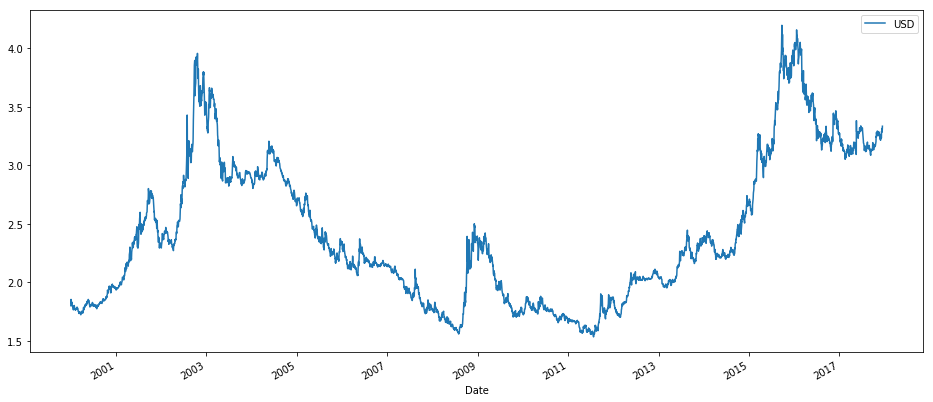

In [4]:
dol.rename(columns={"Value": "USD"}, inplace=True)
dol.plot();

# A variação do dólar: retorno do dólar $x_t$

$$
x_t = \log\left( \frac{p_t}{p_{t-1}} \right)
$$

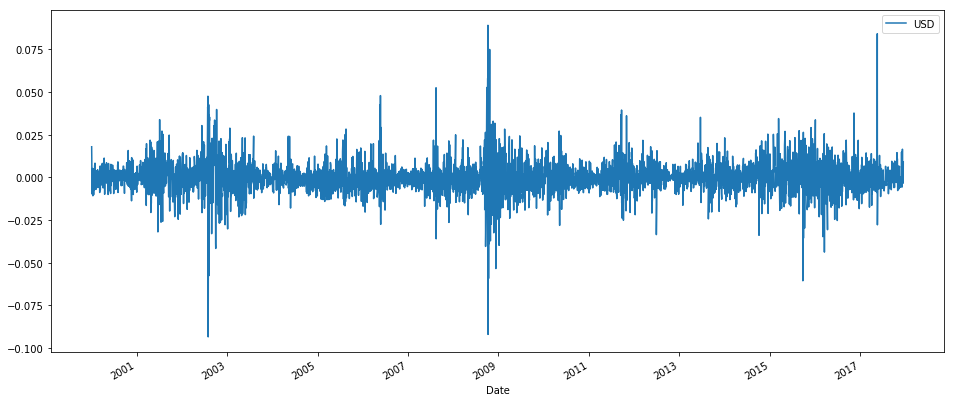

In [5]:
dol_ret = np.log(dol).diff().dropna()
dol_ret.plot();

# O que vamos fazer aqui?

Vamos utilizar 3 técnincas para modelagem de séries temporais para realizar simulações da série do dólar.

- Modelo de média constante

- Modelo autoregressivo - AR(1)

- Modelo de volatilidade - GARCH(1)

Todos os modelos utilizam a série de retornos.

# Um modelo simples para os retornos do dólar

$$
x_t = \mu + \epsilon_t
$$

- $\mu$ é a média dos retornos $x_t$

- $\epsilon_t \sim \mathrm{iid}\, N(0,\sigma^2)$

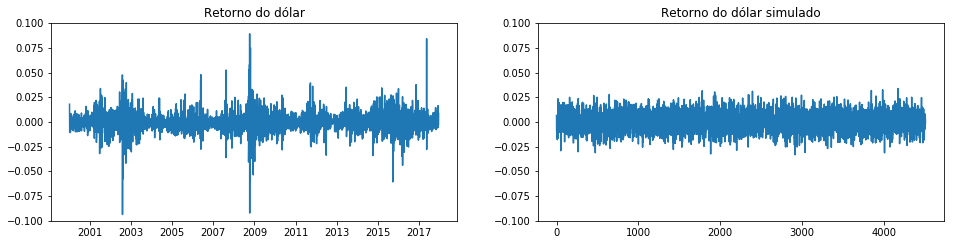

In [6]:
dol_mu = dol_ret.values.mean()
dol_sd = dol_ret.values.std()
dol_sim1 = dol_mu + dol_sd*np.random.randn(len(dol_ret))
plot_two(dol_ret, dol_sim1, [-0.1,0.1], 'Retorno do dólar', 'Retorno do dólar simulado')

## Voltando para os preços

Dados os retornos

$$
x_t = \log\left( \frac{p_t}{p_{t-1}} \right)
$$

Invertemos a equação para voltar aos preços

$$
p_{t} = p_{t-1} \exp{x_t}
$$

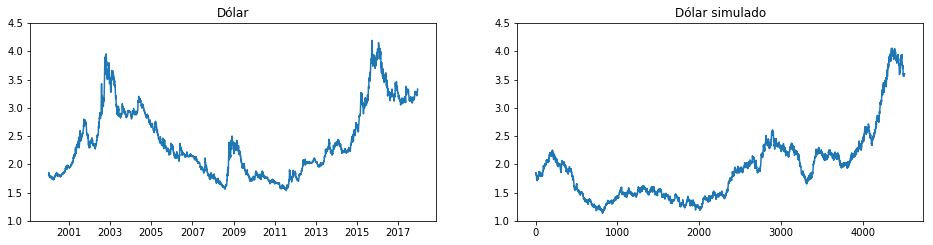

In [7]:
dol1 = np.cumprod(np.r_[dol.values[1], np.exp(dol_sim1)])

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.ylim([1, 4.5])
plt.plot(dol)
plt.title('Dólar')
plt.subplot(222)
plt.ylim([1, 4.5])
plt.plot(dol1)
plt.title('Dólar simulado');


## Vamos complicar um pouco

Vamos assumir que o passado pode explicar o futuro.
<br>
<br>
<br>
$$
x_t = \mu + \phi_1 x_{t-1} + \epsilon_t
$$
<br>
<br>
<br>

- **Processo Autoregressivo** de ordem $1$ = `AR(1)`
- A order do process define até onde o passado pode explicar o futuro
- `AR(1)` faz parte da família `ARIMA`

# `statsmodels`

- Linear regression models
- Generalized linear models
- Discrete choice models
- Robust linear models
- Many models and functions for time series analysis
- Nonparametric estimators
- A collection of datasets for examples
- A wide range of statistical tests
- Input-output tools for producing tables in a number of formats (Text, LaTex, HTML) and for reading Stata files into NumPy and Pandas.
- Plotting functions
- Extensive unit tests to ensure correctness of results

fonte: http://statsmodels.sourceforge.net/

In [8]:
import statsmodels.tsa as tsa
import statsmodels.api as sm

In [9]:
model = sm.tsa.ARMA((dol_ret - dol_mu)/dol_sd, (1, 0)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                    USD   No. Observations:                 4510
Model:                     ARMA(1, 0)   Log Likelihood               -6391.577
Method:                       css-mle   S.D. of innovations              0.998
Date:                Fri, 15 Dec 2017   AIC                          12789.154
Time:                        14:03:37   BIC                          12808.397
Sample:                    01-04-2000   HQIC                         12795.934
                         - 12-14-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.824e-05      0.016      0.002      0.998      -0.031       0.031
ar.L1.USD      0.0589      0.015      3.962      0.000       0.030       0.088
                                    Roots           

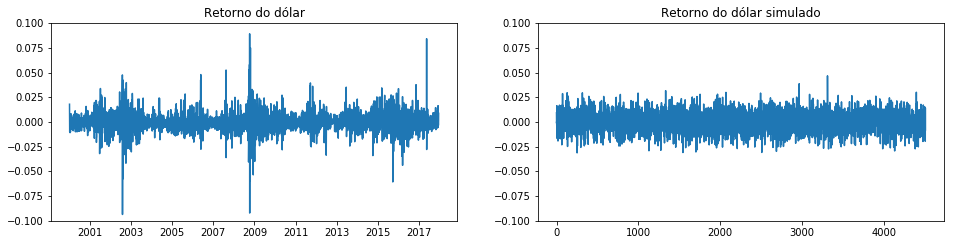

In [21]:
dol_ar_proc = tsa.arima_process.ArmaProcess(np.r_[1, -model.params], [1])
dol_ar_sim = dol_ar_proc.generate_sample(len(dol_ret)) * dol_sd + dol_mu

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.ylim(-0.1,0.1)
plt.plot(dol_ret)
plt.title('Retorno do dólar')
plt.subplot(222)
plt.ylim(-0.1,0.1)
plt.plot(dol_ar_sim)
plt.title('Retorno do dólar simulado');

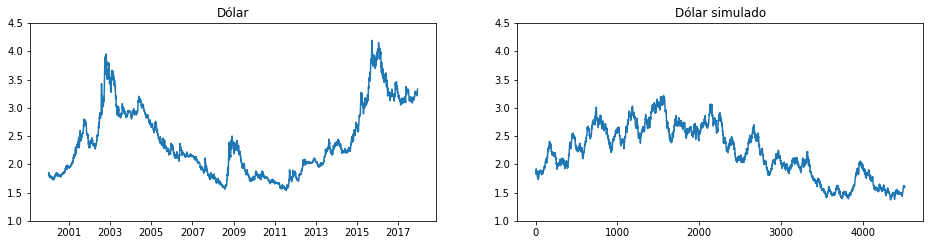

In [22]:
dol1 = np.cumprod(np.r_[dol.values[1], np.exp(dol_ar_sim)])

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.ylim([1, 4.5])
plt.plot(dol)
plt.title('Dólar')
plt.subplot(222)
plt.ylim([1, 4.5])
plt.plot(dol1)
plt.title('Dólar simulado');

## Tendando algo diferente

No AR(p) tinhamos

$$
x_t - \mu = \phi_1 (x_{t-1} - \mu) + ... + \phi_p (x_{t-p} - \mu) + \epsilon_t
$$

Agora vamos assumir que erros do passado podem explicar o futuro.

$$
x_t = \mu + \epsilon_t - \theta_1 \epsilon_{t-1} - ... - \theta_q \epsilon_{t-q}
$$

- **Processo de Média Móvel** de ordem $q$ = `MA(q)`
- O $q$ define até onde os erros do passado podem explicar o futuro
- `MA(q)` faz parte da família `ARIMA`

In [12]:
model = sm.tsa.ARMA(dol_ret/dol_sd, (0, 1)).fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                    USD   No. Observations:                 4510
Model:                     ARMA(0, 1)   Log Likelihood               -6391.149
Method:                       css-mle   S.D. of innovations              0.998
Date:                Fri, 15 Dec 2017   AIC                          12788.298
Time:                        14:03:38   BIC                          12807.540
Sample:                    01-04-2000   HQIC                         12795.077
                         - 12-14-2017                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0142      0.016      0.898      0.369      -0.017       0.045
ma.L1.USD      0.0620      0.015      4.083      0.000       0.032       0.092
                                    Roots           

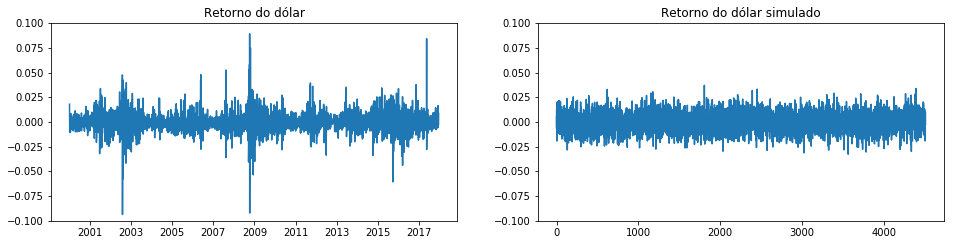

In [13]:
dol_ma_proc = tsa.arima_process.ArmaProcess([1], np.r_[1, model.params])
dol_ma_sim = dol_ma_proc.generate_sample(len(dol_ret))*dol_sd

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.ylim(-0.1,0.1)
plt.plot(dol_ret)
plt.title('Retorno do dólar')
plt.subplot(222)
plt.ylim(-0.1,0.1)
plt.plot(dol_ma_sim)
plt.title('Retorno do dólar simulado');

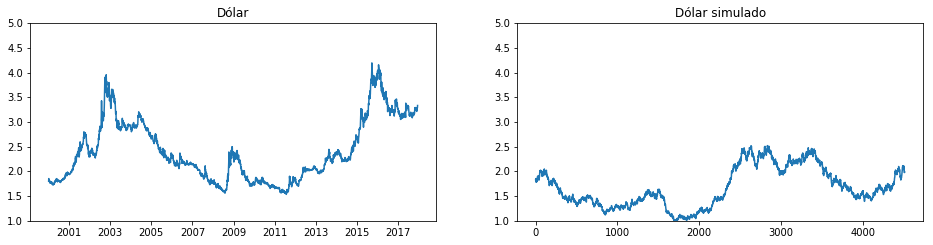

In [14]:
dol1 = np.cumprod(np.r_[dol.values[1], np.exp(dol_ma_sim)])

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.ylim([1, 5])
plt.plot(dol)
plt.title('Dólar')
plt.subplot(222)
plt.ylim([1, 5])
plt.plot(dol1)
plt.title('Dólar simulado');

## Vamos tentar algo realmente diferente


Os modelos da família GARCH
<br>
<br>
<br>
$$
x_t = \mu + \epsilon_t
$$
<br>
<br>
<br>

onde

<br>

$$
\begin{align}
\epsilon_t & = z_t \sigma_t \\
\sigma^2_t & = \omega + \alpha_1 e^2_{t-1} + \beta_1 \sigma^2_{t-1}
\end{align}
$$

<br>

- $z_t \sim N(0, 1)$.

- A variância do processo é um **processo autoregressivo**




# `arch`

The ARCH toolbox currently contains routines for

- Univariate volatility models
- Bootstrapping
- Multiple comparison procedures
- Unit root tests

fonte: http://arch.readthedocs.io/en/latest/

In [15]:
from arch import arch_model
am = arch_model((dol_ret-dol_mu)/dol_sd)
res = am.fit(disp = 'off')
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    USD   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -5443.94
Distribution:                  Normal   AIC:                           10895.9
Method:            Maximum Likelihood   BIC:                           10921.5
                                        No. Observations:                 4510
Date:                Fri, Dec 15 2017   Df Residuals:                     4506
Time:                        14:03:39   Df Model:                            4
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0312  1.206e-02     -2.587  9.673e-

In [16]:
def simulate_garch(params, nobs):
    e = np.random.randn(nobs)
    var = np.zeros(len(e))
    x = np.zeros(len(e))

    for t in range(len(e)):
        var[t] = params[1] + params[2] * x[t-1]**2 + params[3] * var[t-1]
        x[t] = params[0] + e[t] * np.sqrt(var[t])
    
    return x

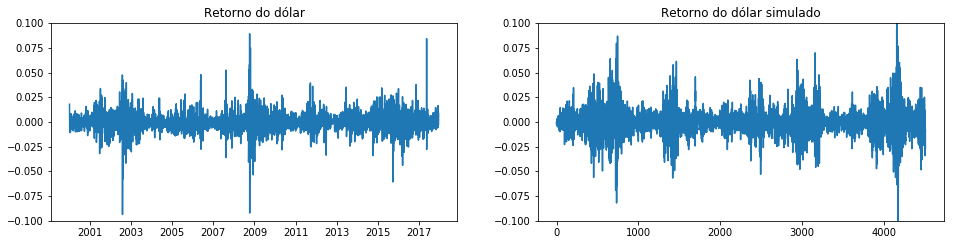

In [19]:
dol_am_sim = simulate_garch(res.params, len(dol_ret)) * dol_sd + dol_mu

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.ylim(-0.1,0.1)
plt.plot(dol_ret)
plt.title('Retorno do dólar')
plt.subplot(222)
plt.ylim(-0.1,0.1)
plt.plot(dol_am_sim)
plt.title('Retorno do dólar simulado');

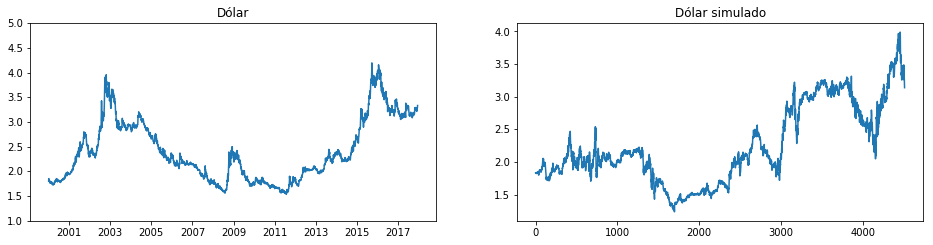

In [20]:
dol1 = np.cumprod(np.r_[dol.values[1], np.exp(dol_am_sim)])

plt.figure(figsize=(16,8))
plt.subplot(221)
plt.ylim([1, 5])
plt.plot(dol)
plt.title('Dólar')
plt.subplot(222)
plt.plot(dol1)
plt.title('Dólar simulado');

## Conclusões


Aqui vimos um breve exemplo de como realizar Modelagem de Séries Temporais com Python.

A Modelagem de Séries Temporais é fundamental para a compreensão da **dinâmica** das séries temporais, particularmente utilizada para modelar séries financeiras.

A modelagem de séries temporais financeiras é utilizada para:

- Trading de Índices de Volatilidade
- Gestão de risco
- Apreçamento de derivativos financeiros
- Modelos de Volatilidade em Séries Intradiárias para avaliação de Risco Intradiário
- Modelos de Cointegração para trading de pares (*pairs trading*)
- Modelos de execução de ordens em condições heterogêneas


## Referências

- http://statsmodels.sourceforge.net/stable/
- https://github.com/bashtage/arch
- http://pandas.pydata.org/


# Dúvidas?